In [38]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices/sample_submission.csv
/kaggle/input/house-prices/data_description.txt
/kaggle/input/house-prices/train.csv
/kaggle/input/house-prices/test.csv


Plan:
1) Load Dataset
2) preview dataset make sure it's compatable with random forest
3) splite dataset into training and validation sets
4) train model
5) visualize model
6) create submission with test data

In [4]:
dataset_df = pd.read_csv('/kaggle/input/house-prices/train.csv')
dataset_df = dataset_df.drop('Id', axis = 1) # drop Id we don't need it
dataset_df.head() #previews first 5 rows

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
dataset_df.info() 
# All values are compatible with decision forest so I dont have to change anything

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
def split_dataset(dataset, test_ratio = 0.20):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_dataset_pd, valid_dataset_pd = split_dataset(dataset_df)
print(f'{train_dataset_pd} Training, {valid_dataset_pd} Validation'.format(len(train_dataset_pd), len(valid_dataset_pd)))


      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
5             50       RL         85.0    14115   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60       RL         62.0     7917   Pave   NaN      Reg   
1456          20       RL         85.0    13175   Pave   NaN      Reg   
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0            Lvl    AllPub    Inside  ...  

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [20]:
train_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_dataset_pd, label = 'SalePrice', task = tfdf.keras.Task.REGRESSION)
valid_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_dataset_pd, label = 'SalePrice', task = tfdf.keras.Task.REGRESSION)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [21]:
tfdf.keras.get_all_models()
# gonna do random forest

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [22]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, num_trees = 100)

Use /tmp/tmp98tkqx0r as temporary training directory


In [23]:
rf.fit(x = train_ds_tf)

Reading training dataset...
Training dataset read in 0:00:00.942444. Found 1178 examples.
Training model...
Model trained in 0:00:00.766672
Compiling model...
Model compiled.


In [24]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

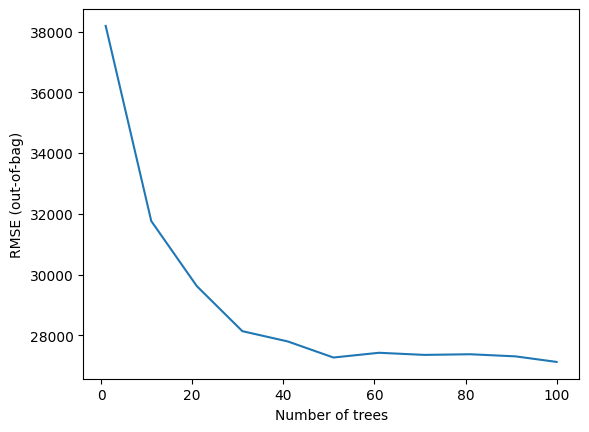

In [25]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [27]:
evaluation = rf.evaluate(x = valid_ds_tf ,return_dict = True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 477ms/step - loss: 0.0000e+00
loss: 0.0000


### Submission

In [48]:
test_data = pd.read_csv('/kaggle/input/house-prices/test.csv')
ids = test_data.pop('Id')
test_data.head()

test_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task = tfdf.keras.Task.REGRESSION)

prediction = [pred[0] for pred in rf.predict(test_ds_tf)]

output = pd.DataFrame({'Id': ids, 'SalePrice': prediction})

output.head()

2/2 [==============================] - 0s 14ms/step


,Id,SalePrice
0,1461,128075.265625
1,1462,154188.031250
2,1463,178631.734375
3,1464,185192.859375
4,1465,190608.265625


In [59]:
output.to_csv("submission.csv", index=False)
print("Submission file saved ✅")

Submission file saved ✅


In [60]:
pd.read_csv("submission.csv").head()

,Id,SalePrice
0,1461,128075.266
1,1462,154188.030
2,1463,178631.730
3,1464,185192.860
4,1465,190608.270
